#### Bibliotecas

In [1]:
from datetime import datetime
from time import time
from contextlib import contextmanager
from typing import List, Union
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr,kruskal
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from tsai.all import *
import optuna
from optuna.integration import FastAIPruningCallback

os.environ["DEVICE"] = "cuda"

In [221]:
import os
from pathlib import WindowsPath, PosixPath

class Pl(WindowsPath if os.name == 'nt' else PosixPath):
    pass

In [227]:
os.name

'posix'

In [143]:
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

### Carregando os dados

In [2]:
set_seed(1, False)
@contextmanager
def cwd(path: str) -> None:

    """
    Context manager para mudar o diretório de trabalho.
    Mantém o diretório original após a execução do bloc
    
    o de código.
    """

    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

In [3]:
with cwd('dados/TrainTestVal_dataset/'):
    y_labels = pd.read_csv('y_labels.csv')['localidade']
    gpp_cax_test,gpp_peru_test,gpp_santarem_test = [pd.read_csv(f'dados_datasetTeste/{x}') for x in sorted(os.listdir('dados_datasetTeste'))]
    X_test,X_train,X_val,y_test,y_train,y_val = [np.load(data) for data in sorted([x for x in os.listdir() if not(x in ['dados_datasetTeste','y_labels.csv',".ipynb_checkpoints"])])]

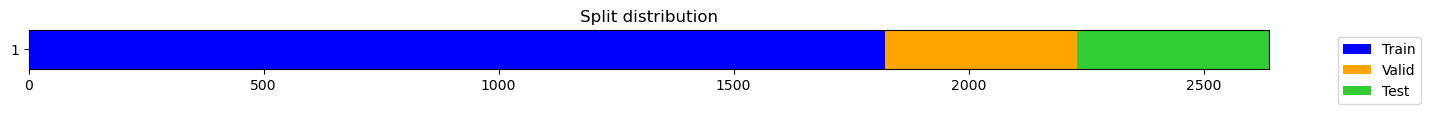

[1822, 408, 408]

In [4]:
X, y, splits = combine_split_data(xs=[X_train, X_val, X_test], ys=[y_train, y_val, y_test])
plot_splits(splits)

tfms = [None, TSForecasting()]
get_splits_len(splits) # [1806, 408, 408] ~= 70%,15%,15%

# Testes com as arquiteturas

In [5]:
archs = [
         XCMPlus,
         ConvTranPlus,
         TSSequencerPlus,      # Arquiteturas que estamos utilizando.
         RNNPlus,              
         ResNetPlus,                            
         InceptionTimePlus,
         TSTPlus,
         TransformerLSTMPlus,
         XceptionTimePlus, 
         TransformerGRUPlus,
         PatchTST,
        ]

resultados = {}


def test_archs(epochs):
    for arch in archs:
        print(arch.__name__)
        results = pd.DataFrame(columns=['arch', 'total params', 'train loss', 'valid loss', 'mae_valid','rmse_valid','time','epochs'])
        i=0
        learn = TSForecaster(X, y, splits=splits, tfms=tfms, batch_tfms=TSStandardize(), arch=arch, metrics=[mae,rmse],device=default_device(),loss_func=HuberLoss('mean'))
        start = time.time()
        resultados[f'{arch.__name__}'] = {'train loss':[], 'valid loss':[], 'MAE':[],'RMSE':[]}
        for epoch in range(1,epochs+1):
            learn.fit_one_cycle(1, lr_max=1e-05)
            resultados[f'{arch.__name__}']['train loss'].append(learn.recorder.values[-1][0])
            resultados[f'{arch.__name__}']['valid loss'].append(learn.recorder.values[-1][1])
            resultados[f'{arch.__name__}']['MAE'].append(learn.recorder.values[-1][2])
            resultados[f'{arch.__name__}']['RMSE'].append(learn.recorder.values[-1][3])
            if ((epoch % 50) == 0):
                folder_path = f"./modelos/"
                if not os.path.exists(folder_path):
                    os.makedirs(folder_path)
                elapsed = time.time() - start
                vals = learn.recorder.values[-1]
                results.loc[i] = [arch.__name__, count_parameters(learn.model), vals[0], vals[1], vals[2],vals[3], int(elapsed),epoch]
                results.sort_values(by=['valid loss'], ascending=False, kind='stable', ignore_index=True, inplace=True)
                clear_output()
                display(results)
                i+=1
        results.to_csv(f'./modelos/{arch.__name__}_resultados_{epochs}_epocas.csv')

test_archs(600)

,arch,total params,train loss,valid loss,mae_valid,rmse_valid,time,epochs
0,PatchTST,6318090,8.273975,8.237536,8.704081,9.129760,26,50
1,PatchTST,6318090,7.800347,8.069210,8.470812,9.755292,104,200
2,PatchTST,6318090,7.915424,8.058500,8.486402,9.425593,78,150
3,PatchTST,6318090,8.059578,8.048683,8.487839,9.153543,52,100
4,PatchTST,6318090,7.502047,7.921514,8.200249,10.361818,182,350
5,PatchTST,6318090,7.572687,7.878562,8.191134,10.020743,156,300
6,PatchTST,6318090,7.657687,7.828025,8.188474,9.673945,130,250
7,PatchTST,6318090,7.371114,7.813194,8.063769,10.481366,208,400
8,PatchTST,6318090,7.314523,7.774930,7.999770,10.670572,235,450
9,PatchTST,6318090,7.167265,7.622473,7.873918,10.628362,261,500


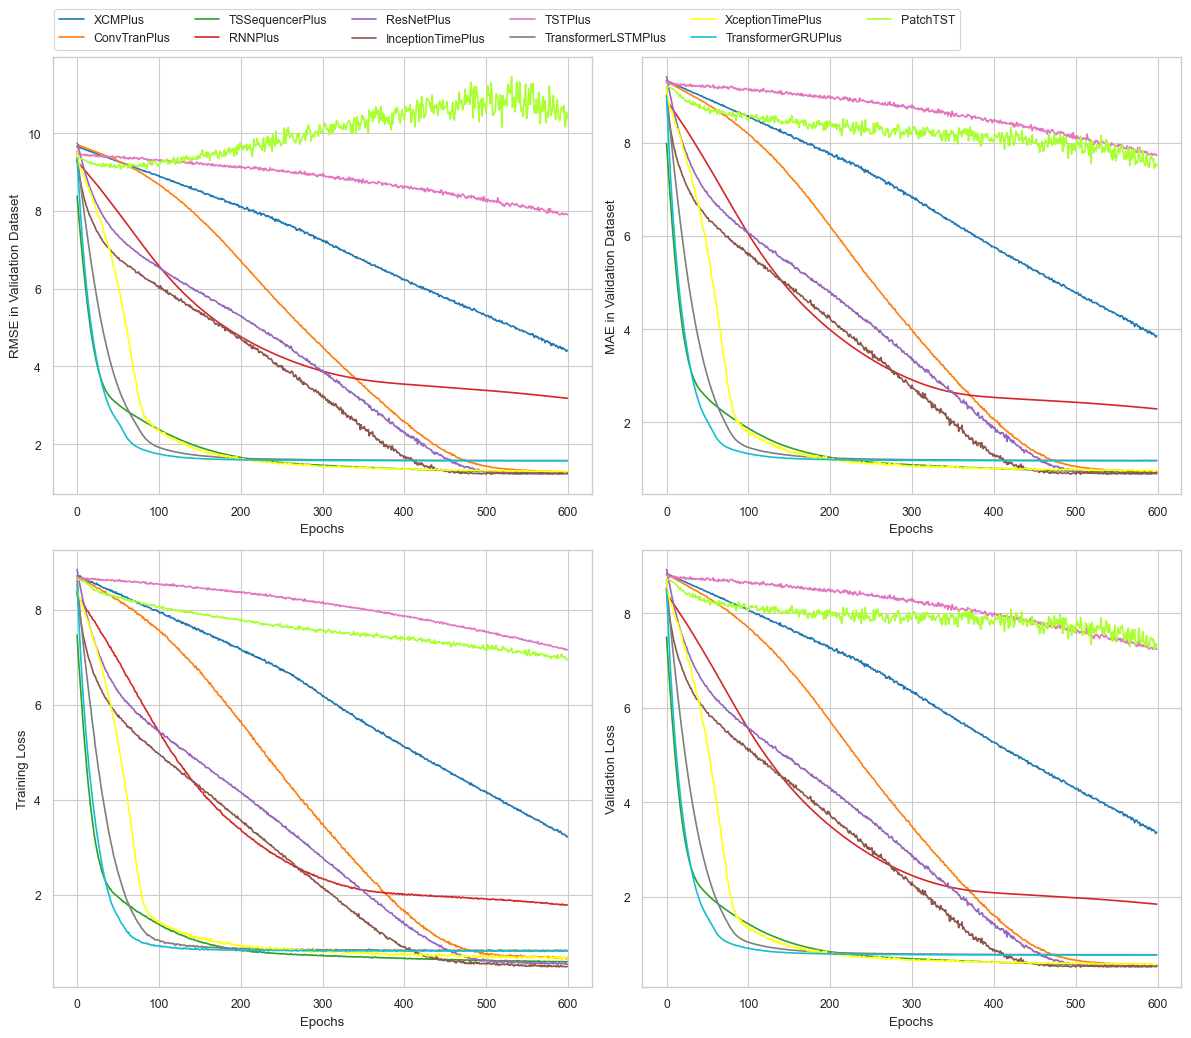

In [98]:
# Define plot line colors
colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # gray
    '#ffff14',  # yellow
    '#17becf',  # cyan
    '#aaff32'   # lime
]


# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot RMSE on validation dataset
for idx, archs in enumerate(resultados.keys()):
    axs[0, 0].plot(range(len(resultados[archs]['RMSE'])), resultados[archs]['RMSE'], label=archs, color=colors[idx])
axs[0, 0].set_ylabel('RMSE in Validation Dataset')
axs[0, 0].set_xlabel('Epochs')

# Plot MAE on validation dataset
for idx, archs in enumerate(resultados.keys()):
    axs[0, 1].plot(range(len(resultados[archs]['MAE'])), resultados[archs]['MAE'], label=archs, color=colors[idx])
axs[0, 1].set_ylabel('MAE in Validation Dataset')
axs[0, 1].set_xlabel('Epochs')

# Plot training loss
for idx, archs in enumerate(resultados.keys()):
    axs[1, 0].plot(range(len(resultados[archs]['train loss'])), resultados[archs]['train loss'], label=archs, color=colors[idx])
axs[1, 0].set_ylabel('Training Loss')
axs[1, 0].set_xlabel('Epochs')

# Plot validation loss
for idx, archs in enumerate(resultados.keys()):
    axs[1, 1].plot(range(len(resultados[archs]['valid loss'])), resultados[archs]['valid loss'], label=archs, color=colors[idx])
axs[1, 1].set_ylabel('Validation Loss')
axs[1, 1].set_xlabel('Epochs')

# Adjust layout to avoid overlap
plt.subplots_adjust(top=0.85)  # Adjust top margin
plt.tight_layout()

# Get handles and labels for the legend
handles, labels = axs[0, 0].get_legend_handles_labels()

# Place legend outside the box, in the upper side of the plot
# bbox_to_anchor=  [up: (x, 2.25); down: (x, -0.1); left: (-0.25,y); right : (0.15,y)]
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(-0.25, 2.25), ncol=(len(resultados)/2)+1) 

# seaborn style
sns.set_style()
sns.set_style("whitegrid")
#sns.set_style("darkgrid")
#sns.set_context("paper")

# Display the plot
plt.savefig('./archs_result_plot.jpeg', bbox_inches='tight', format='jpeg', dpi=300)
plt.show()



In [ ]:
# Dictionary to store minimum y value for each architecture
min_train_values = {}
min_valid_values = {}

for archs in resultados.keys():
    # Calculate the minimum y value and store in the dictionary
    min_train_values[archs] = min(resultados[archs]['train loss'])
    min_valid_values[archs] = min(resultados[archs]['valid loss'])
    
# Convert dictionary to DataFrame
df_min_train_values = pd.DataFrame(min_train_values.items(), columns=['Architecture', 'Min_Train_Value'])
df_min_valid_values = pd.DataFrame(min_valid_values.items(), columns=['Architecture', 'Min_Valid_Value'])

# Write DataFrame to a CSV file
df_min_train_values.to_csv('min_train_values.csv', index=False)
df_min_valid_values.to_csv('min_valid_values.csv', index=False)


In [120]:
with cwd('./modelos'):
    arquiteturas = [x for x in sorted(os.listdir()) if x.endswith('600_epocas.csv')]
    linhas = []
    for i in arquiteturas:
        df = pd.read_csv(i).iloc[-1]
        linhas.append(df)
new_df = pd.concat(linhas,axis=1).transpose()
#new_df = new_df.drop(new_df.columns[0])
sorted_df = new_df.sort_values(by='valid loss')
sorted_df.to_csv('min_valid_rows_sorted.csv', index=False)


In [80]:
### PLOTS INDIVIDUAIS


# for archs in resultados.keys():
#     plt.plot(range(len(resultados[archs]['RMSE'])),resultados[archs]['RMSE'],label=archs)
# plt.legend(loc='upper right')
# plt.ylabel('RMSE in Valid Dataset')
# plt.xlabel('Epochs')
# plt.show()


# for archs in resultados.keys():
#     plt.plot(range(len(resultados[archs]['MAE'])),resultados[archs]['MAE'],label=archs)
# plt.legend(loc='upper right')
# plt.ylabel('RMSE in Valid Dataset')
# plt.xlabel('Epochs')
# plt.show()

# for archs in resultados.keys():
#     plt.plot(range(len(resultados[archs]['train loss'])),resultados[archs]['train loss'],label=archs)
# plt.legend(loc='upper right')
# plt.ylabel('RMSE in Valid Dataset')
# plt.xlabel('Epochs')
# plt.show()


# for archs in resultados.keys():
#     plt.plot(range(len(resultados[archs]['valid loss'])),resultados[archs]['valid loss'],label=archs)
# plt.legend(loc='upper right')
# plt.ylabel('RMSE in Valid Dataset')
# plt.xlabel('Epochs')
# plt.show()

# Otimização do modelo selecionado com o Optuna

In [ ]:
def objective_InceptionTimePlus(trial):
    # Definir os hiperparâmetros para otimização
    nf = trial.suggest_int('nf', 16, 128)
    fc_dropout = trial.suggest_float('fc_dropout', 0.0, 0.9)
    ks = trial.suggest_int('ks', 10, 100)
    conv_dropout = trial.suggest_float('conv_dropout', 0.0, 0.9)
    sa = trial.suggest_categorical('sa', [True, False])
    se = trial.suggest_categorical('se', [True, False])
    arch_config = {
        'nf': nf,
        'fc_dropout': fc_dropout,
        'ks': ks,
        'conv_dropout': conv_dropout,
        'sa': sa,
        'se': se
    }
    learning_rate_model = trial.suggest_float("learning_rate_model", 1e-5, 1e-2, log=True)
    Huber_delta = trial.suggest_float("Huber_delta", 1, 2)
    standardize_sample = trial.suggest_categorical('by_sample', [True, False])
    standardize_var = trial.suggest_categorical('by_var', [True, False])
    arch = InceptionTimePlus  # Corrigir a arquitetura para InceptionTimePlus
    
    # Definir a instância do TSForecaster com os callbacks
    learn = TSForecaster(X, y, splits=splits, path='models', tfms=tfms,
                         batch_tfms=TSStandardize(by_sample=standardize_sample, by_var=standardize_var),
                         arch=arch, arch_config=arch_config, metrics=[rmse],
                         cbs=[
                             FastAIPruningCallback(trial),
                             SaveModel(monitor='_rmse', comp=np.less, fname='best_model',with_opt=True,verbose=True),
                             EarlyStoppingCallback(monitor='_rmse',comp=np.less, patience=15)
                         ],
                         device=device, loss_func=HuberLoss('mean', Huber_delta), seed=1)
    
    with ContextManagers([learn.no_bar()]):
        learn.fit_one_cycle(550, lr_max=learning_rate_model)
        # Carregar o melhor modelo salvo
        learn.load('best_model')
        # Obter o valor de RMSE da melhor época
        intermediate_value = learn.recorder.values[-1][-1]
    
    # Salvar o modelo e os resultados do trial
    folder_path = "./optuna_tests/objective_InceptionTimePlus/"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    file_path = os.path.join(folder_path, "{}.pickle".format(trial.number))
    if os.path.exists(file_path):
        os.remove(file_path)
    
    with open(file_path, "wb") as fout:
        pickle.dump(learn, fout)
    
    return intermediate_value

# Configurar e rodar o estudo Optuna
study_ic = run_optuna_study(objective_InceptionTimePlus,sampler= optuna.samplers.TPESampler(n_startup_trials=500,seed=1),
                            n_trials=1500,gc_after_trial=True,direction="minimize",show_plots=False)

print(f"O Melhor modelo foi o de número {study_ic.best_trial.number}")
print("Best hyperparameters: ", study_ic.best_trial.params)

In [145]:
optuna.importance.get_param_importances(study_ic)

{'learning_rate_model': 0.7693193393367211,
 'conv_dropout': 0.1515292669916033,
 'by_sample': 0.03308165767997393,
 'sa': 0.013827622917404928,
 'fc_dropout': 0.009598110939053776,
 'nf': 0.007785150802083102,
 'ks': 0.007615844587523373,
 'Huber_delta': 0.005826574004569317,
 'se': 0.0009300169707525796,
 'by_var': 0.0004864157703144993}

# Avaliação do Melhor Modelo

In [222]:
#temp = pathlib.PosixPath
#pathlib.PosixPath = pathlib.WindowsPath

with open(f"./optuna_tests/objective_InceptionTimePlus/{study_ic.best_trial.number}.pickle", "rb") as fin:
    learner = pickle.load(fin)

In [223]:
raw_preds, target, preds = learner.get_X_preds(X[splits[2]], y[splits[2]])

In [224]:
preds_df = pd.concat([pd.DataFrame(raw_preds),y_labels.to_frame()],axis=1)
target_df = pd.concat([pd.DataFrame(y_test),y_labels.to_frame()],axis=1)

dfs_preds = {}
dfs_target = {}

for localidade in preds_df['localidade'].unique():
    dfs_preds[localidade] = preds_df[preds_df['localidade'] == localidade]

for localidade in target_df['localidade'].unique():
    dfs_target[localidade] = target_df[target_df['localidade'] == localidade]

# Acessando os DataFrames separados

df_peru_pred = dfs_preds['peru'].drop('localidade',axis=1)
df_santarem_pred = dfs_preds['santarem'].drop('localidade',axis=1)
df_caxiuana_pred = dfs_preds['caxiuana'].drop('localidade',axis=1)

df_peru_target = dfs_target['peru'].drop('localidade',axis=1)
df_santarem_target = dfs_target['santarem'].drop('localidade',axis=1)
df_caxiuana_target = dfs_target['caxiuana'].drop('localidade',axis=1)

In [225]:
datas_conj_teste = gpp_peru_test.loc[gpp_peru_test['peru'].isin(y[splits[2]].flatten())]['index']
datas_conj_teste = pd.to_datetime(datas_conj_teste)

In [226]:
import matplotlib.dates as mdates

def get_summary(df_pred,df_target):
    results = {}
    for i in dfs_preds:
        mae_test = mean_absolute_error(y_pred=df_pred[i].drop('localidade',axis=1),y_true=df_target[i].drop('localidade',axis=1))
        mse_test = mean_squared_error(y_pred=df_pred[i].drop('localidade',axis=1),y_true=df_target[i].drop('localidade',axis=1))
        rmse_test = np.sqrt(mse_test)
        r2_test = r2_score(y_pred=df_pred[i].drop('localidade',axis=1),y_true=df_target[i].drop('localidade',axis=1))
        results[i] = [r2_test,mae_test,rmse_test,np.corrcoef(df_pred[i].drop('localidade',axis=1).values.flatten(), df_target[i].drop('localidade',axis=1).values.flatten())[0][1]]

        residuos = df_pred[i].drop('localidade',axis=1).values - df_target[i].drop('localidade',axis=1).values
        plt.figure(figsize=(30, 9))
        plt.subplot(2, 1, 1)

        plt.plot(datas_conj_teste, df_pred[i].drop('localidade',axis=1).values.flatten(), label='Previsões', alpha=1)
        plt.plot(datas_conj_teste, df_target[i].drop('localidade',axis=1).values.flatten(), label='Valores reais', alpha=0.7)
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

        for label in plt.gca().get_xticklabels(which='major'):
            label.set(rotation=30, horizontalalignment='right')

        plt.xlabel('Índice da observação')
        plt.ylabel('Valor')
        plt.title(f'Comparação entre Previsões e Valores Reais ({i})')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(2, 1, 2)
        plt.plot(datas_conj_teste,residuos.flatten(), label='Resíduos', color='red')

        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

        for label in plt.gca().get_xticklabels(which='major'):
            label.set(rotation=30, horizontalalignment='right')

        plt.xlabel('Índice da observação')
        plt.ylabel('Resíduo')
        plt.title(f'Resíduos {i} (Previsões - Valores reais)')
        plt.legend()
        plt.grid(True)

        # Seu código para mostrar os gráficos
        plt.tight_layout()
        plt.show()

        residuos_flatten = residuos.flatten()

        # Criar figura e eixos para o subplot
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Plot do residual plot
        sns.scatterplot(x=df_pred[i].drop('localidade',axis=1).values.flatten(), y=residuos_flatten, ax=axes[0])
        axes[0].set_title(f'Residual Plot ({i})')
        axes[0].set_xlabel('Valores Previstos')
        axes[0].set_ylabel('Resíduos')

        # Plot do histograma dos resíduos
        sns.histplot(residuos_flatten, ax=axes[1])
        axes[1].set_title(f'Histograma dos Resíduos ({i})')
        axes[1].set_xlabel('Resíduos')
        axes[1].set_ylabel('Contagem')

        # Ajuste o layout
        plt.tight_layout()
        plt.show()


    return pd.DataFrame(results,index=['R²','MAE','RMSE','Corr'])

df_regioes = get_summary(dfs_preds,dfs_target)

AttributeError: type object 'PurePath' has no attribute '_flavour'

<Figure size 3000x900 with 0 Axes>

In [208]:
mae_geral = mean_absolute_error(raw_preds,target)
mse_geral = mean_squared_error(raw_preds,target)
rmse_geral = np.sqrt(mse_geral)
r2_geral = r2_score(y_pred=raw_preds,y_true=target)

resultados_geral = {}
resultados_geral['Geral'] = [r2_geral,mae_geral,mse_geral,np.corrcoef(raw_preds.flatten(), target.flatten())[0][1]]
resultados_geral = pd.DataFrame(resultados_geral,index=df_regioes.index)

df_geral = pd.concat([df_regioes,resultados_geral],axis=1)
display(df_geral)

NameError: name 'df_regioes' is not defined